**Testing the UCMerced Image Captioning Model**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import pickle
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


**Load trained model for testing**

In [0]:
from keras.models import load_model

# Returns a compiled model identical to the previous one
model = load_model('/content/drive/My Drive/Colab Notebooks/UC_model_weights/ucmodel.h5')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where












**Test Image file names**

In [0]:
listt=[0,22,3,7,12,13,21,25,32,36,54,56,131,177,183,46,63,101,129,147,64,76,78,91,99,111,112,165,180,191,197,200]

**Image file path**

In [0]:
images = '/content/drive/My Drive/Colab Notebooks/ucm/'

**Loading Encoded Test Image features**

In [0]:
with open("/content/drive/My Drive/Colab Notebooks/UCPickle/uc_encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

**Loading Vocabulary file for captioning**

In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/content/drive/My Drive/Colab Notebooks/ucmercedcaptions.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1.tif#0	There is a piece of farmland .
1.tif#1	There is a piece of cropland .
1.tif#2	It is a piece of farmland .
1.tif#3	It is a piece of cropland .
1.tif#4	Here is a piece of farmland .
2.tif#0	There is a piece of farmland .
2.tif#1	There is a piece of cropland .
2.tif#2	It is a piece of farmland 


In [0]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '/content/drive/My Drive/Colab Notebooks/ucmercedtrain.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 1890


In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions


# descriptions
train_descriptions = load_clean_descriptions('/content/drive/My Drive/Colab Notebooks/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=1890


In [0]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

9450

In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 333 -> 249


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

**Looping through all test images for generating captions**

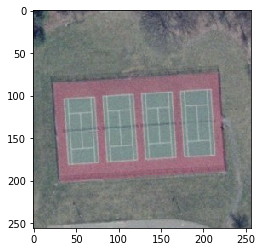

Caption: there are two tennis courts arranged neatly and surrounded by some plants




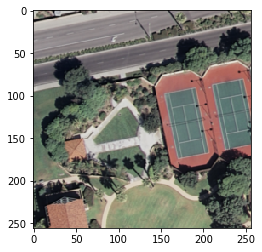

Caption: there are some buildings with cars parked beside them




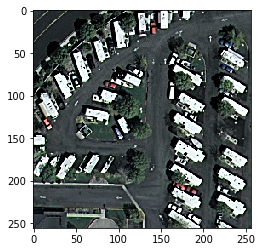

Caption: there are lots of houses arranged in lines




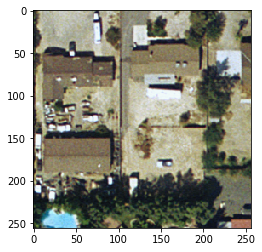

Caption: there are lots of houses arranged neatly and road goes through them




IndexError: ignored

In [0]:
max_length=23
x1=list(encoding_test.keys())
for i in listt:
  pic = list(encoding_test.keys())[i]
  # print(pic)
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  print("Caption:",greedySearch(image))
  print("\n")